In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import visualization
from utils.simulations import *
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
folder_path = './dataset/Simulations_4/'  # change to your folder path
file_names = os.listdir(folder_path)
results_kmdist = []
results_logrank = []
# Display the file names
for name in file_names:
    if 'results_log_rank' in name:
        print(name)
        results_logrank.append(pd.read_csv(folder_path + name,index_col=0))
    if 'results_survival_km_distance' in name:
        print(name)
        results_kmdist.append(pd.read_csv(folder_path + name,index_col=0))
results_kmdist = pd.concat(results_kmdist)
results_kmdist = results_kmdist.sort_values(by='XP_num')
results_logrank = pd.concat(results_logrank)
results_logrank = results_logrank.sort_values(by='XP_num')

results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_51to60.csv
results_log_rank_test_n_samples_600_n_features_bytype_6_MC_51to60.csv
results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_11to20.csv
results_log_rank_test_n_samples_600_n_features_bytype_6_MC_91to100.csv
results_log_rank_test_n_samples_600_n_features_bytype_6_MC_71to80.csv
results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_1to10.csv
results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_71to80.csv
results_log_rank_test_n_samples_600_n_features_bytype_6_MC_1to10.csv
results_log_rank_test_n_samples_600_n_features_bytype_6_MC_11to20.csv
results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_61to70.csv
results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_81to90.csv
results_log_rank_test_n_samples_600_n_features_bytype_6_MC_31to40.csv
results_log_rank_test_n_samples_600_n_features_bytype_6_MC_81to90.csv
results_survival_km_distance_n_samples_600_n_feat

In [3]:
# folder_path = './dataset/Simulations_4/'  # change to your folder path
# results = pd.read_csv(folder_path + 'results_n_samples_600n_features_bytype_6.csv', index_col=0)

In [4]:
# results_ext = pd.concat(results, ignore_index=True)
results_kmdist_ext = results_kmdist.copy(deep=True)
results_logrank_ext = results_logrank.copy(deep=True)
treat_effects = np.unique(results_kmdist_ext.H0_coef.values)
generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise", "Surv-GAN", "Surv-VAE"]
# generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise"]

In [5]:
for col in results_kmdist_ext.columns:
    results_kmdist_ext[col] = np.float64(results_kmdist_ext[col].values)

for col in results_logrank_ext.columns:
    results_logrank_ext[col] = np.float64(results_logrank_ext[col].values)

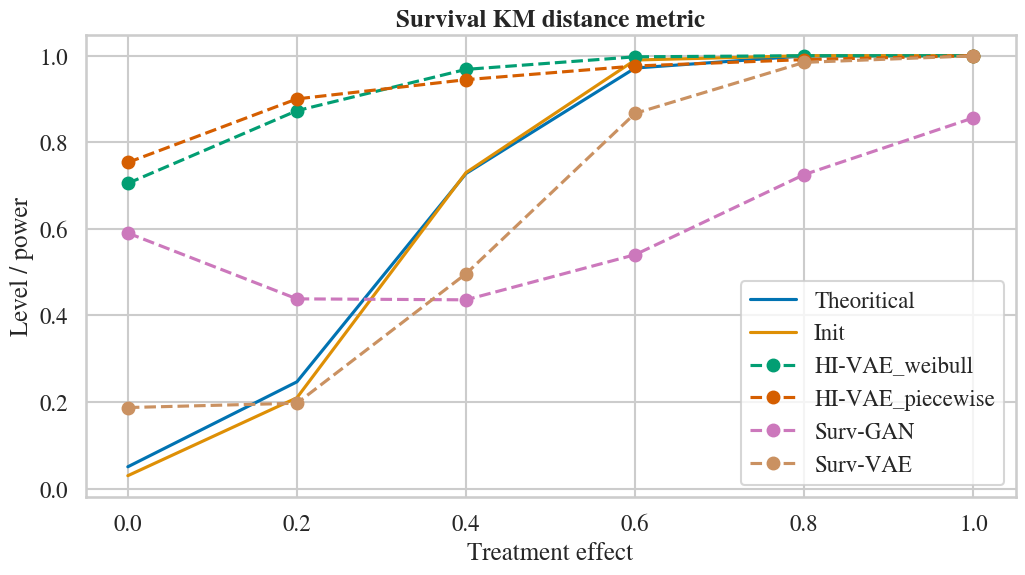

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
H0_coef_univ_theo = results_kmdist_ext.groupby("H0_coef").mean()["H0_coef_univ"].to_numpy()
D_control_theo = results_kmdist_ext.groupby("H0_coef").mean()["D_control"].to_numpy()
D_treated_theo = results_kmdist_ext.groupby("H0_coef").mean()["D_treated"].to_numpy()
power_theo = []
for i in range(len(H0_coef_univ_theo)):
    power_theo.append(cpower(D_control_theo[i], D_treated_theo[i], H0_coef_univ_theo[i], 0.05))
ax.plot(treat_effects, np.array(power_theo), label = "Theoritical")

results_kmdist_ext["reject_H0_init"] = results_kmdist_ext['log_pvalue_init'] > -np.log(0.05)
power_init = results_kmdist_ext.groupby("H0_coef").mean()["reject_H0_init"].to_numpy()
ax.plot(treat_effects, power_init, '-', label = "Init")

custom_palette = ['deepskyblue','darkblue','orange', 'red']
for i, generator_name in enumerate(generators_sel):
    results_kmdist_ext["reject_H0_gen_" + generator_name] = results_kmdist_ext['log_pvalue_' + generator_name] > -np.log(0.05)
    power_gen = results_kmdist_ext.groupby("H0_coef").mean()["reject_H0_gen_" + generator_name].to_numpy()
    ax.plot(treat_effects, power_gen, '--', marker='o', label = generator_name,)

plt.xlabel("Treatment effect")
plt.ylabel("Level / power")
plt.title("Survival KM distance metric", fontweight='semibold')
plt.legend()
plt.show()
# plt.savefig("./dataset/" + dataset_name + "/results_independent_n_samples_" + str(n_samples) + "n_features_bytype_" + str(n_features_bytype) + ".jpeg")

In [ ]:
H0_coef_univ_theo = results_logrank_ext.groupby("H0_coef").mean()["H0_coef_univ"].to_numpy()
D_control_theo = results_logrank_ext.groupby("H0_coef").mean()["D_control"].to_numpy()
D_treated_theo = results_logrank_ext.groupby("H0_coef").mean()["D_treated"].to_numpy()
power_theo = []
for i in range(len(H0_coef_univ_theo)):
    power_theo.append(cpower(D_control_theo[i], D_treated_theo[i], H0_coef_univ_theo[i], 0.05))

results_logrank_ext["reject_H0_init"] = results_logrank_ext['log_pvalue_init'] > -np.log(0.05)
power_init = results_logrank_ext.groupby(["XP_num", "H0_coef"]).mean().reset_index()
power_init_sel = power_init[["H0_coef"]]
power_init_sel["reject_H0"] = power_init["reject_H0_init"]
power_init_sel["Method"] = "Init"
power_gen_df = pd.DataFrame()
for i, generator_name in enumerate(generators_sel):
    results_logrank_ext["reject_H0_gen_" + generator_name] = results_logrank_ext['log_pvalue_' + generator_name] > -np.log(0.05)
    power_gen = results_logrank_ext.groupby(["XP_num", "H0_coef"]).mean().reset_index()
    power_gen_sel = power_gen[["H0_coef"]]
    power_gen_sel["reject_H0"] = power_gen["reject_H0_gen_" + generator_name]
    power_gen_sel["Method"] = generator_name
    power_gen_df = pd.concat([power_gen_df, power_gen_sel])
power_df = pd.concat([power_init_sel, power_gen_df])

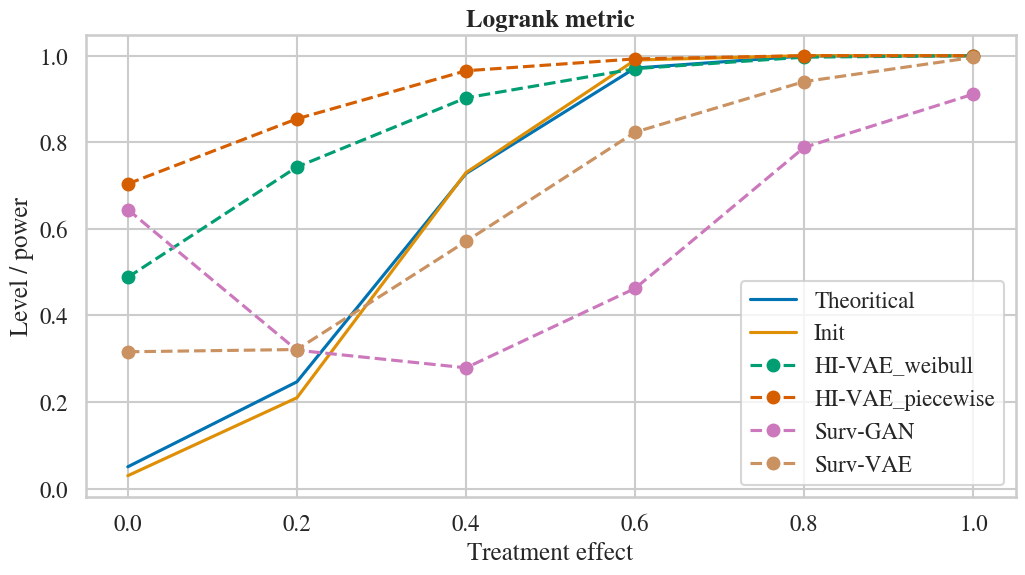

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))
H0_coef_univ_theo = results_logrank_ext.groupby("H0_coef").mean()["H0_coef_univ"].to_numpy()
D_control_theo = results_logrank_ext.groupby("H0_coef").mean()["D_control"].to_numpy()
D_treated_theo = results_logrank_ext.groupby("H0_coef").mean()["D_treated"].to_numpy()
power_theo = []
for i in range(len(H0_coef_univ_theo)):
    power_theo.append(cpower(D_control_theo[i], D_treated_theo[i], H0_coef_univ_theo[i], 0.05))
ax.plot(treat_effects, np.array(power_theo), label = "Theoritical")

results_logrank_ext["reject_H0_init"] = results_logrank_ext['log_pvalue_init'] > -np.log(0.05)
power_init = results_logrank_ext.groupby("H0_coef").mean()["reject_H0_init"].to_numpy()
ax.plot(treat_effects, power_init, '-', label = "Init")

custom_palette = ['deepskyblue','darkblue','orange', 'red']
for i, generator_name in enumerate(generators_sel):
    results_logrank_ext["reject_H0_gen_" + generator_name] = results_logrank_ext['log_pvalue_' + generator_name] > -np.log(0.05)
    power_gen = results_logrank_ext.groupby("H0_coef").mean()["reject_H0_gen_" + generator_name].to_numpy()
    ax.plot(treat_effects, power_gen, '--', marker='o', label = generator_name,)

plt.xlabel("Treatment effect")
plt.ylabel("Level / power")
plt.title("Logrank metric", fontweight='semibold')
plt.legend()
plt.show()
# plt.savefig("./dataset/" + dataset_name + "/results_independent_n_samples_" + str(n_samples) + "n_features_bytype_" + str(n_features_bytype) + ".jpeg")

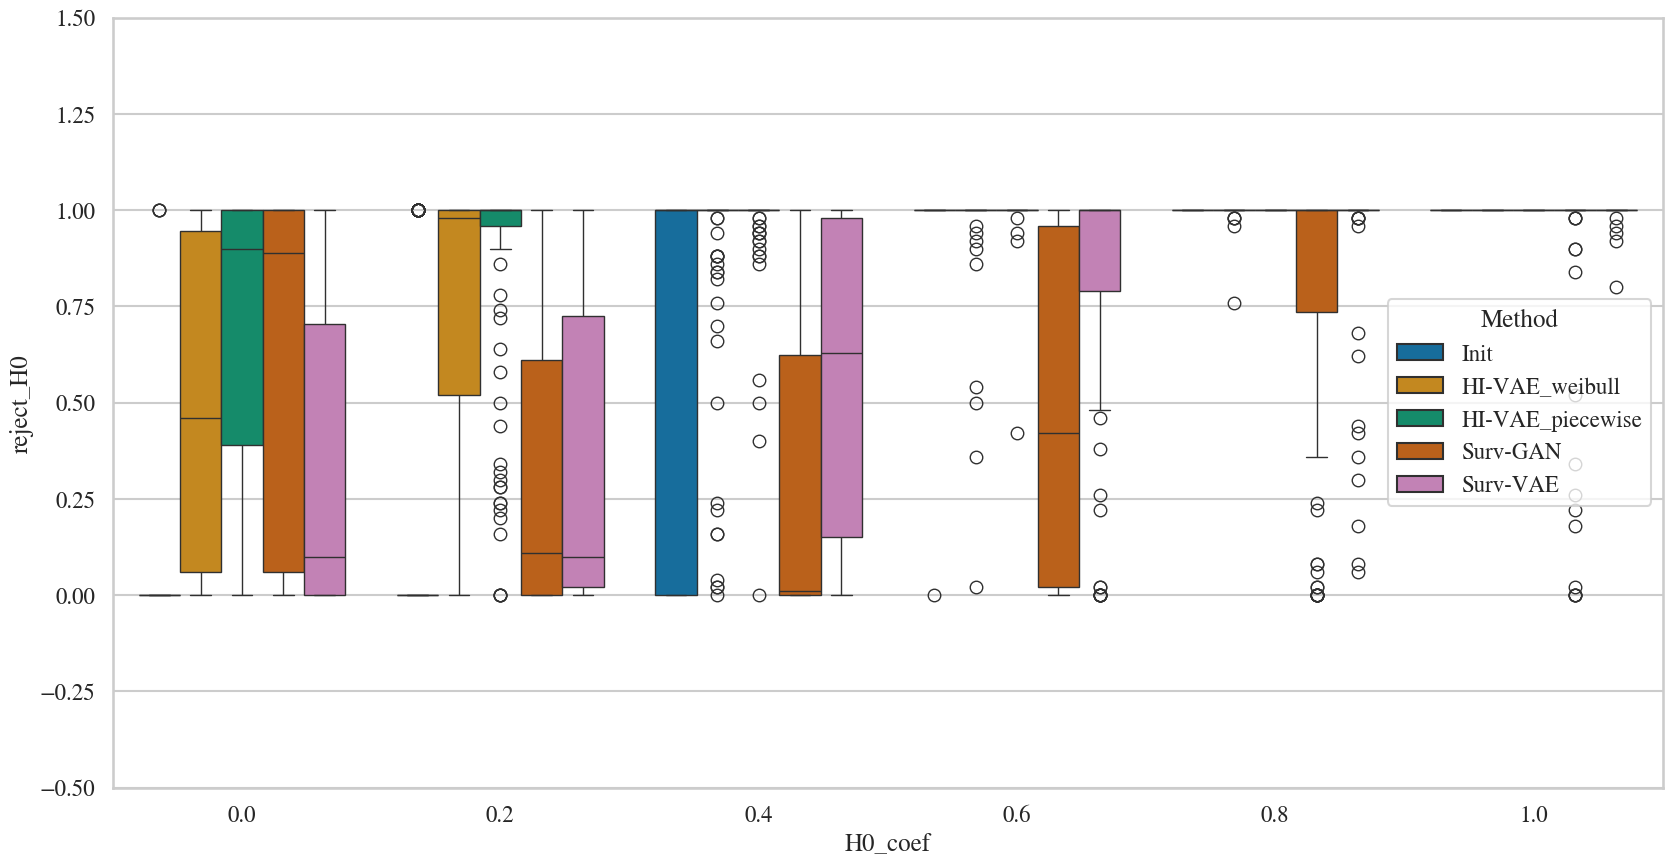

In [ ]:
plt.figure(figsize=(20, 10))
sns.boxplot(x='H0_coef', y='reject_H0', hue="Method", data=power_df)
plt.ylim(-0.5, 1.5)
plt.xticks(ticks=np.arange(len(treat_effects)), labels=[str(int(te * 100) / 100) for te in treat_effects])
plt.show()

In [37]:
def visualize_synthcity_metric_res(results, metrics, title):
    num_metrics = len(metrics)
    n_learners = len(generators_sel)
    fig, axs = plt.subplots(1, num_metrics, figsize=(5 * num_metrics * n_learners, 10))

    if num_metrics == 1:
        axs = [axs]  # ensure axs is iterable

    for i, ax in enumerate(axs):
        # Format axis spines
        metric_name, opt = metrics[i]
        metric_df = pd.DataFrame()
        for generator_name in generators_sel:
            metric_df = pd.concat([metric_df, pd.DataFrame(np.array([[generator_name] * results.shape[0], 
                                                            results[metric_name + "_" + generator_name]]).T,
                                                            columns=['generator', metric_name])])
        metric_df[metric_name] = np.float64(metric_df[metric_name].values)
        for spine in ax.spines.values():
            spine.set_linewidth(2)
            spine.set_edgecolor('black')

        sns.boxplot(data=metric_df, x='generator', y=metric_name, ax=ax,
                    linewidth = 3, saturation = 1, palette = 'colorblind', 
                    width = 1, gap = 0.15, whis = 0.8, linecolor="Black")
        ax.set_xlabel('')
        ax.set_ylabel(metric_name, fontsize=30, fontweight="semibold")
        ax.tick_params(axis='x', labelsize=25)
        ax.tick_params(axis='y', labelsize=25)
        if opt == "max":
            ax.legend(title='Maximize \u2191', title_fontsize=15)
        else:
            ax.legend(title='Minimize \u2193', title_fontsize=15)
    plt.tight_layout(pad=3)
    fig.suptitle(title, fontsize=35, fontweight='semibold')

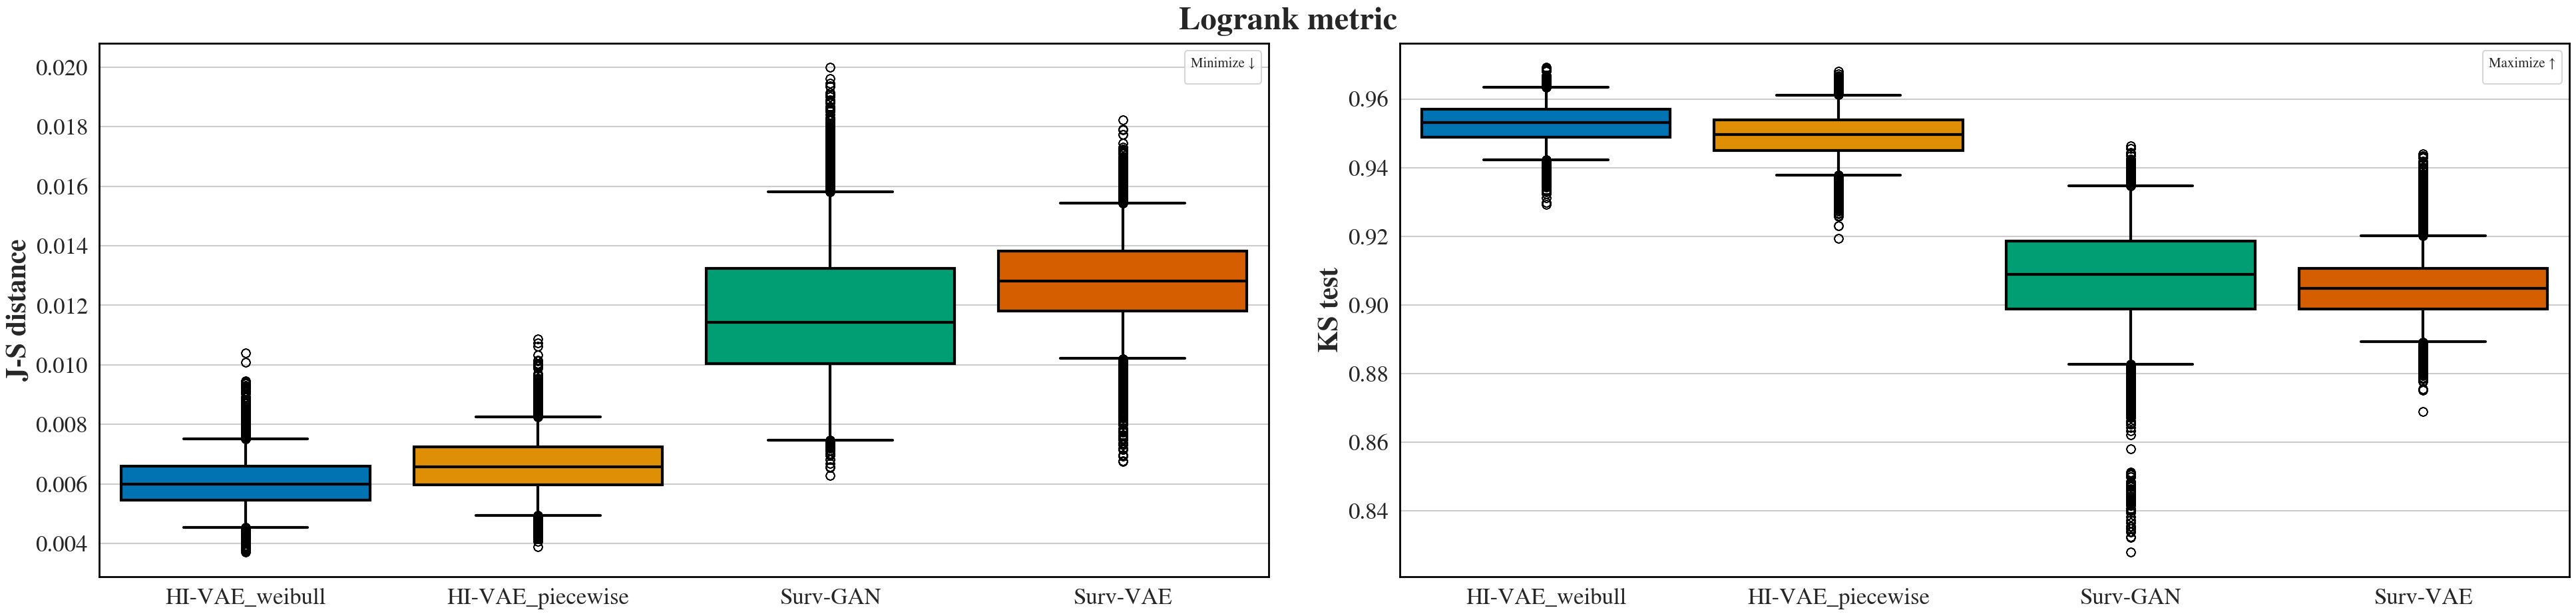

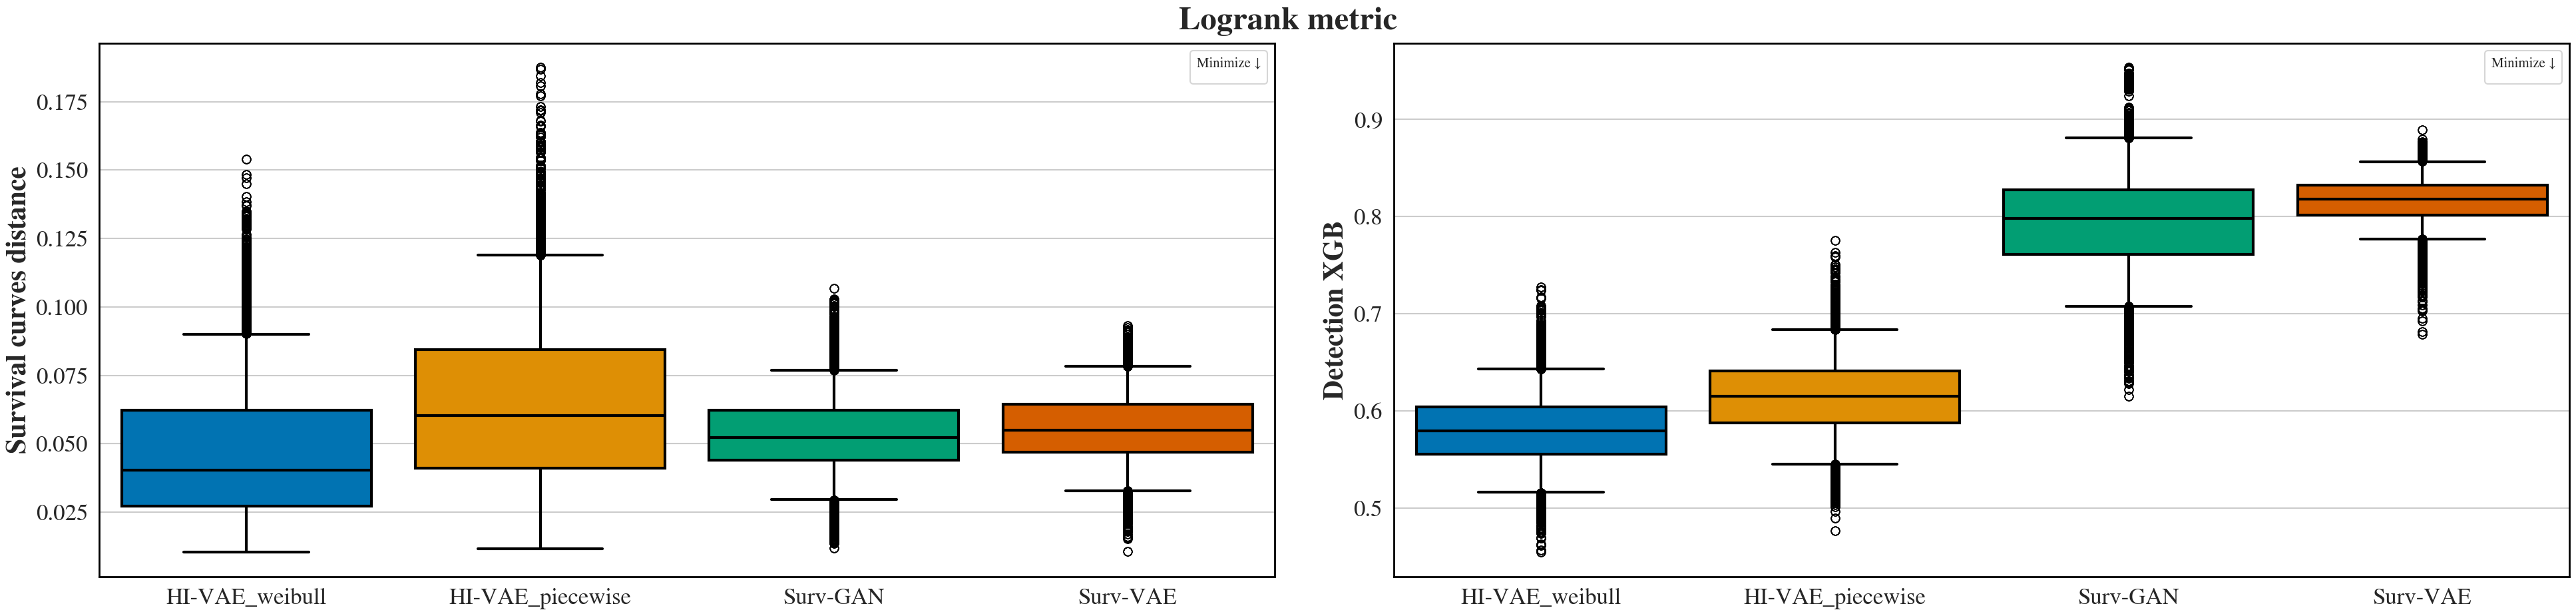

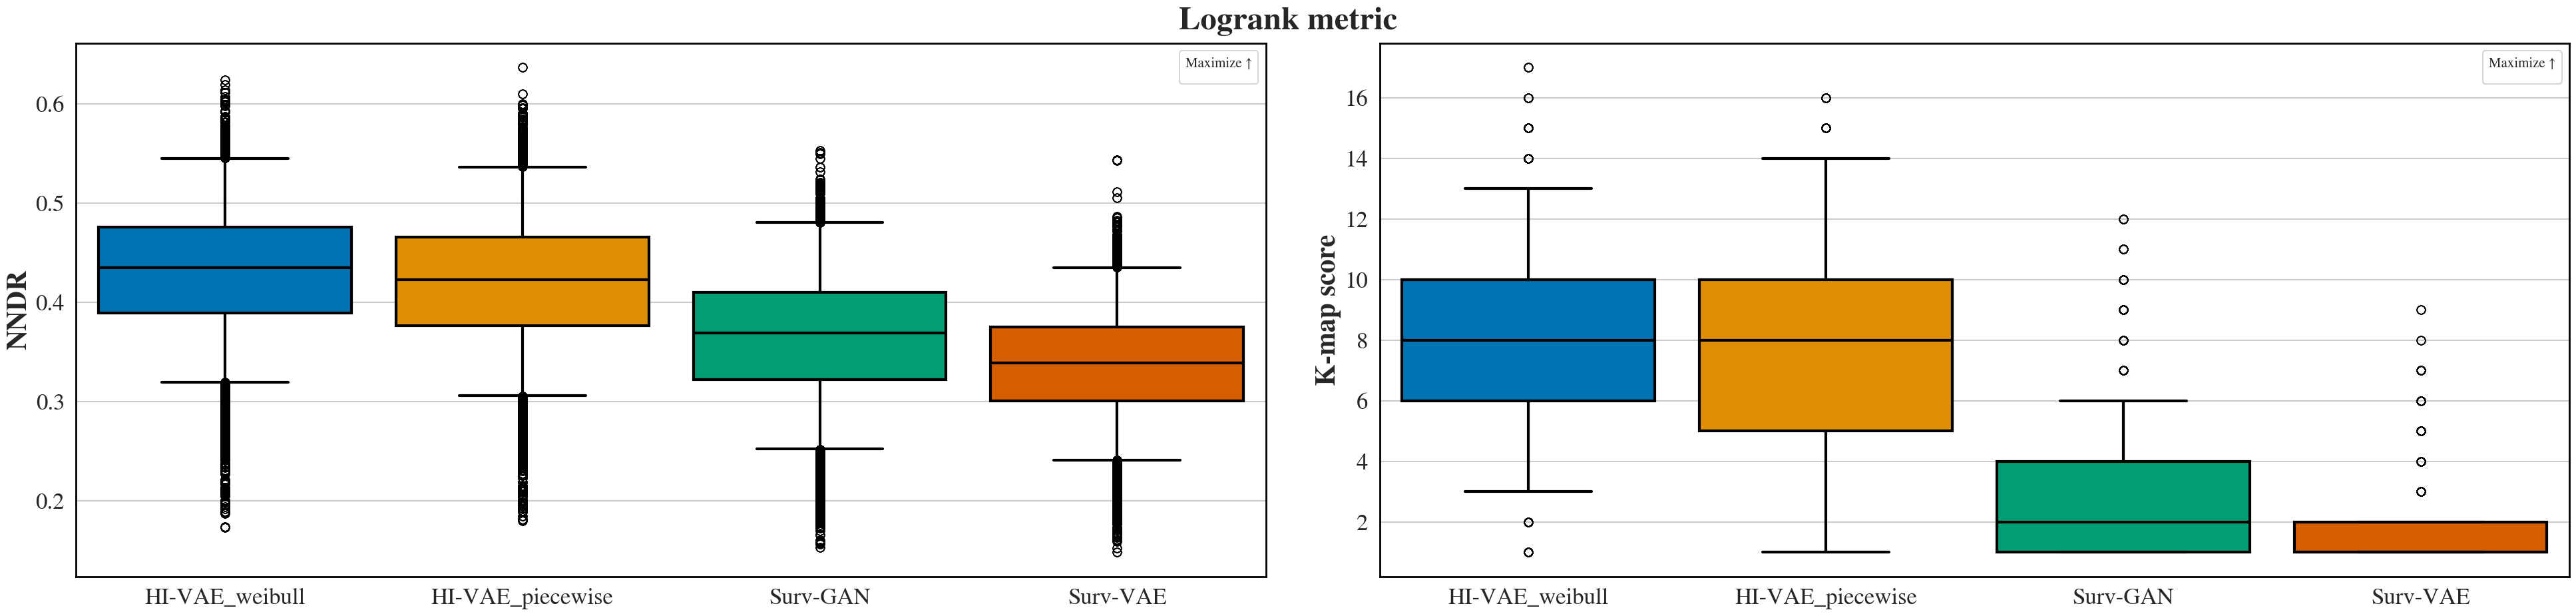

In [42]:
#### SYNTHCITY METRICS 
for metrics in [[['J-S distance', "min"], ['KS test', "max"]],
                [['Survival curves distance', "min"], ['Detection XGB', "min"]],
                [['NNDR', "max"], ['K-map score', "max"]]]:
    visualize_synthcity_metric_res(results_logrank, metrics, 'Logrank metric')

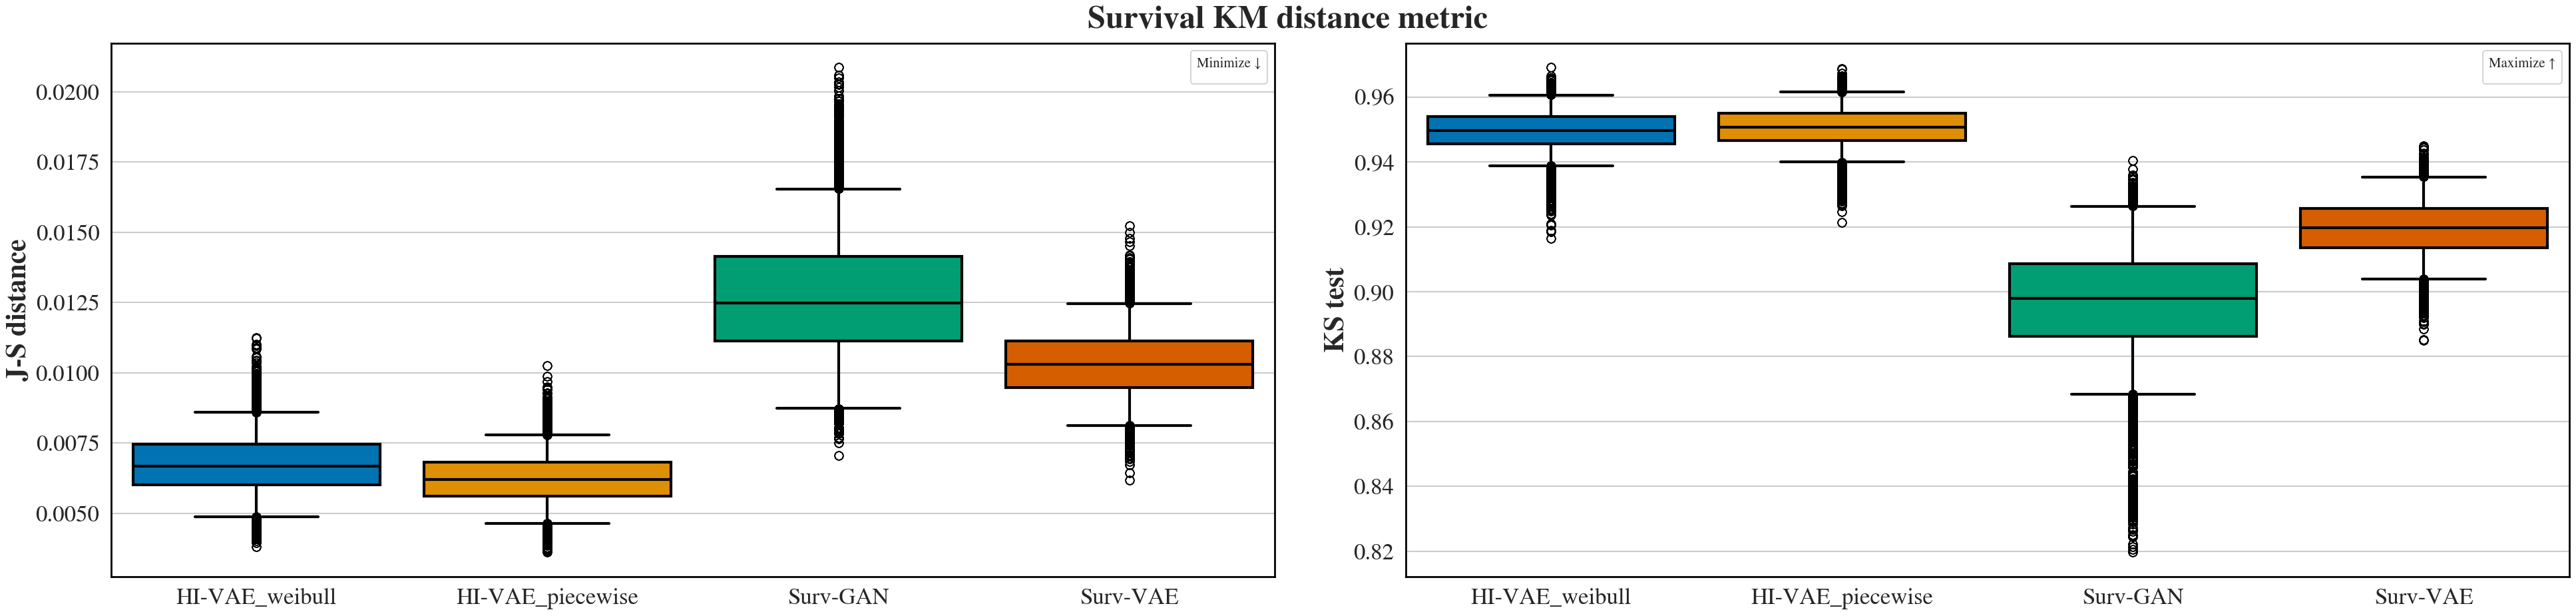

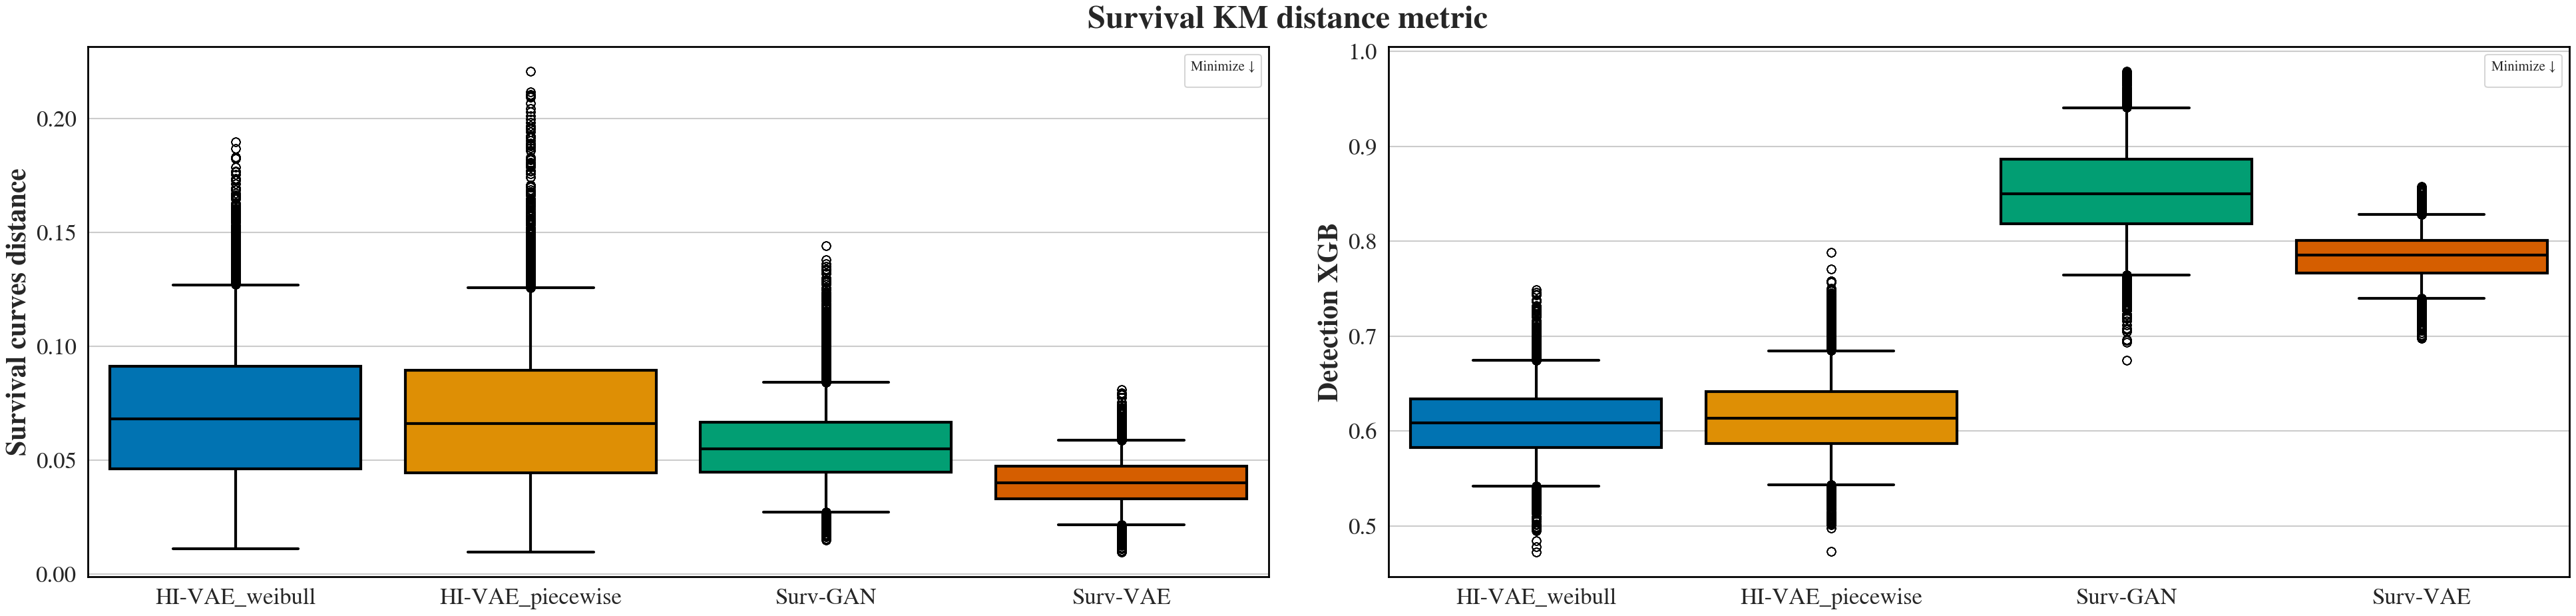

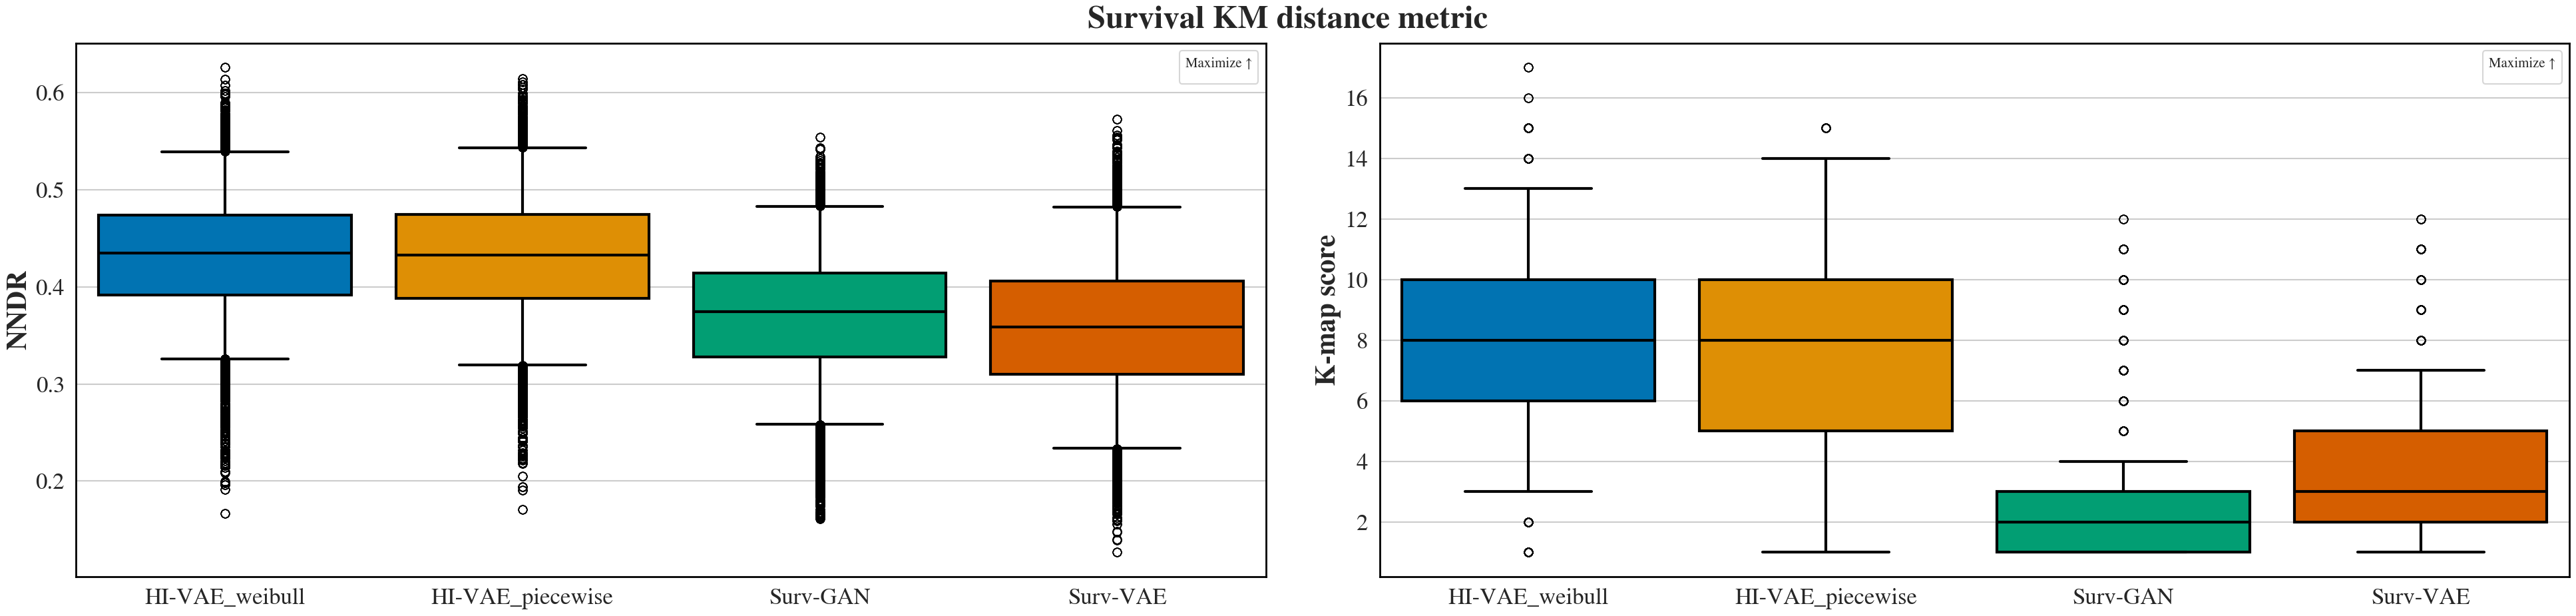

In [43]:
#### SYNTHCITY METRICS 
for metrics in [[['J-S distance', "min"], ['KS test', "max"]],
                [['Survival curves distance', "min"], ['Detection XGB', "min"]],
                [['NNDR', "max"], ['K-map score', "max"]]]:
    visualize_synthcity_metric_res(results_kmdist, metrics, 'Survival KM distance metric')

In [42]:
n_MC_exp = 100
from utils.metrics import estimate_agreement, decision_agreement, standardized_difference, ci_overlap
columns = ['time', 'censor', 'treatment']

# score_df = pd.DataFrame(columns=["Generator", "Treatment_effect", "MC_exp", "Nb generated datasets", "Estimate agreement", "Decision agreement", "Standardized difference", "CI overlap"])
score_df = pd.DataFrame(columns=["Generator", "Nb generated datasets", "Estimate agreement", "Decision agreement", "Standardized difference", "CI overlap"])
for treatment_effect in treat_effects:
    results_treat = results_kmdist_ext[results_kmdist_ext.H0_coef == treatment_effect]
    cox_init = results_treat[["est_cox_coef_init", "est_cox_coef_se_init"]].drop_duplicates().values
    for m in range(n_MC_exp):
        results_MC = results_treat[(results_treat[["est_cox_coef_init", "est_cox_coef_se_init"]] == cox_init[m]).all(axis=1)]
        coef_init, se_init = results_MC[["est_cox_coef_init", "est_cox_coef_se_init"]].drop_duplicates().values[0]
        ci_init = (coef_init - 1.96 * se_init, coef_init + 1.96 * se_init)

        for generator in generators_sel:
            coef_syn, se_syn = results_MC[["est_cox_coef_" + generator, "est_cox_coef_se_" + generator]].values.T
            max_len_samples = len(coef_syn)
            list_len_samples = np.arange(int(.2 * max_len_samples), max_len_samples, int(.2 * max_len_samples)).tolist()
            if max_len_samples not in list_len_samples:
                list_len_samples += [max_len_samples]
            for j in list_len_samples:
                coef_syn_, se_syn_ = np.array(coef_syn)[:j], np.array(se_syn)[:j]
                coef_syn_mean = coef_syn_.mean()
                var_syn_mean = (se_syn_**2).mean()
                # imputation_var_syn = (1 / (len(coef_syn) - 1)) * np.sum([(coef_syn_ - coef_syn_mean)**2 for coef_syn_ in coef_syn])
                # adjusted_var_syn = (imputation_var_syn / len(coef_syn)) + var_syn_mean
                adjusted_var_syn = (1/j + 1) * var_syn_mean
                ci_syn = (coef_syn_mean - 1.96 * np.sqrt(adjusted_var_syn), coef_syn_mean + 1.96 * np.sqrt(adjusted_var_syn))

                res = [estimate_agreement(ci_init, coef_syn_mean),
                    decision_agreement(coef_init, ci_init, coef_syn_mean, ci_syn),
                    standardized_difference(coef_init, coef_syn_mean, se_init),
                    ci_overlap(ci_init, ci_syn)]

                # score_df.loc[len(score_df)] = [generator, treatment_effect, m, j] + res
                score_df.loc[len(score_df)] = [generator, j] + res

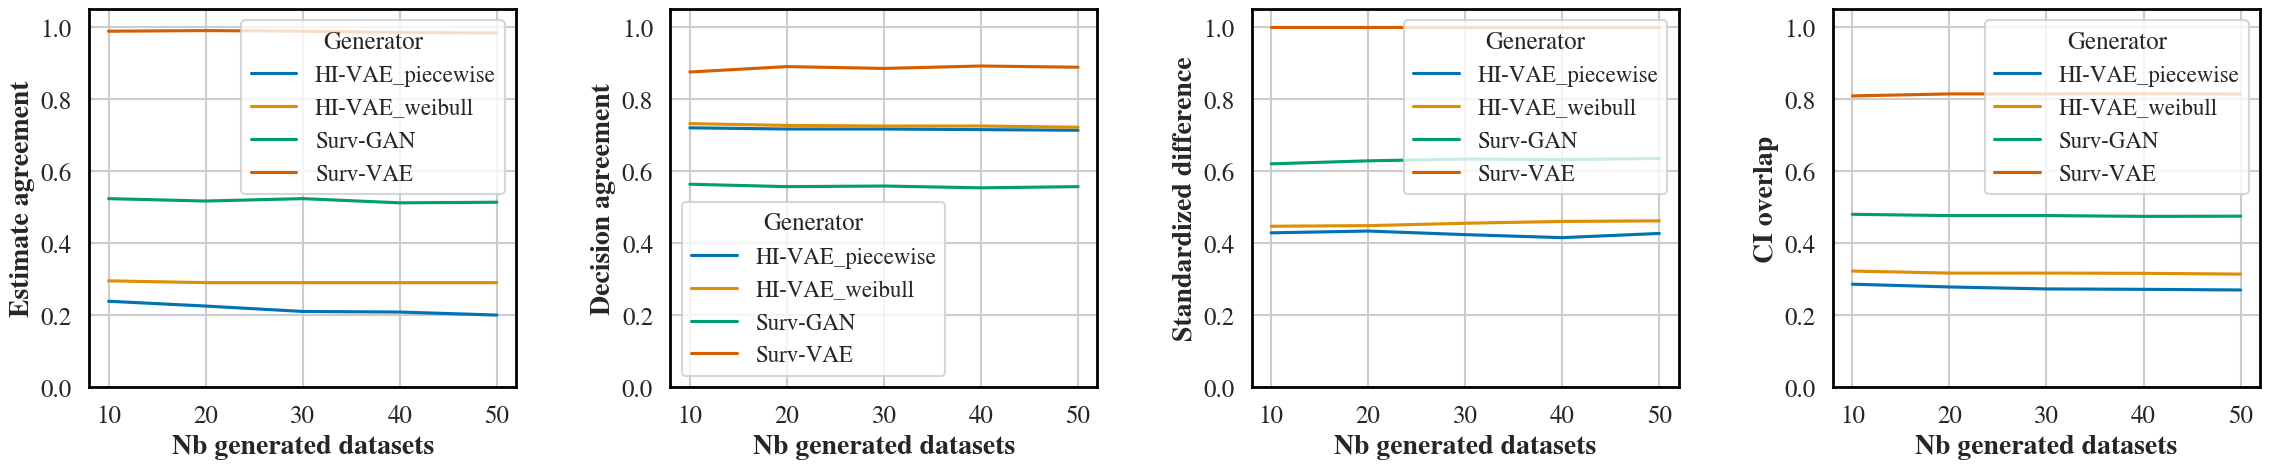

In [43]:
from utils.visualization import visualize_replicability_perf
visualize_replicability_perf(score_df.groupby(['Generator', 'Nb generated datasets'], as_index=False).mean())